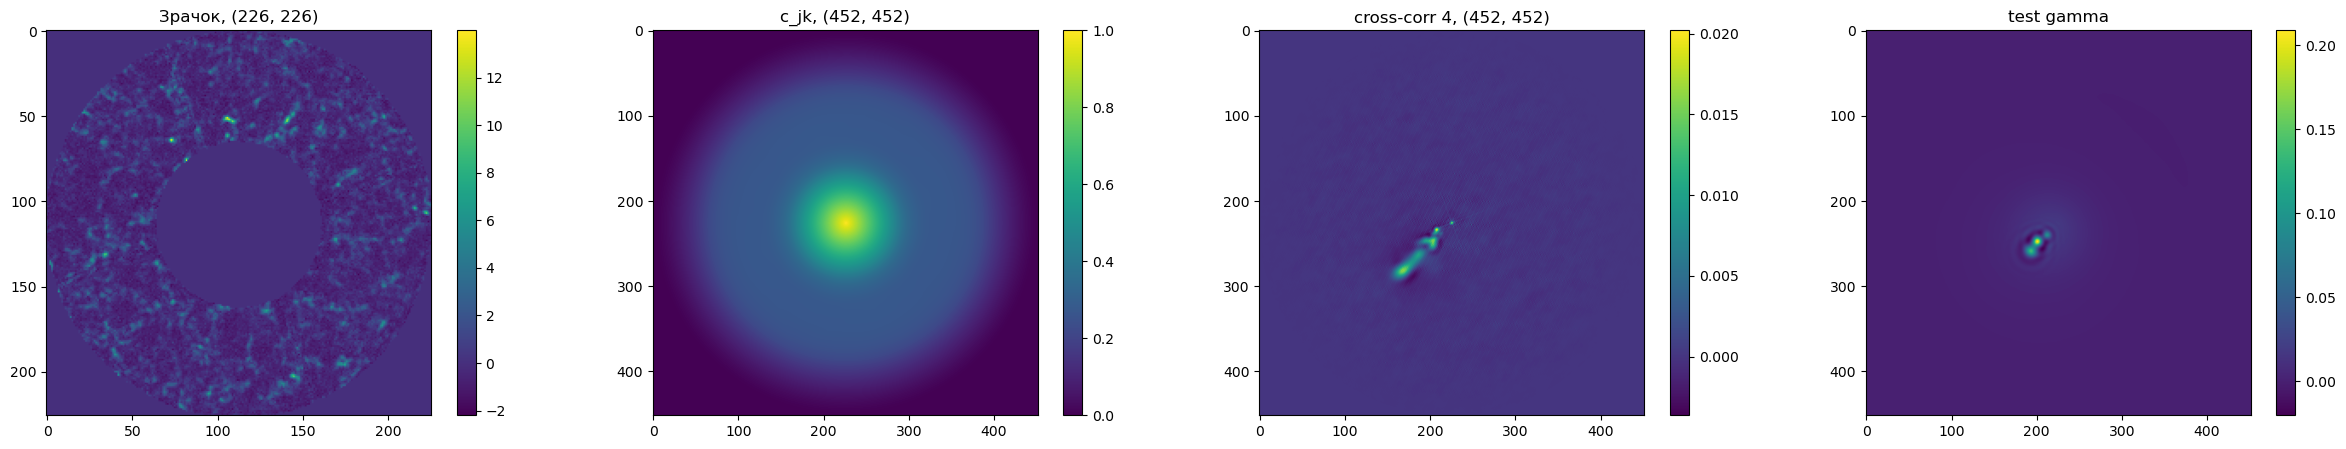

In [7]:
import time
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import shift
from scipy.optimize import curve_fit
from skimage.filters import threshold_multiotsu, threshold_otsu, median

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    
    if idx == (len(array) - 1):
        return idx, idx-1
    if idx == 0:
        return 1, 0
    else:
        if array[idx] > value:
            return idx, idx-1 
        if array[idx] < value:
            return idx+1, idx

def gamma_poly_se(X, Y, Vx, Vy, Cn2, z):
    global cjk, t, a1, gammas, delta
    
    Lx = Vx*t
    Ly = Vy*t
    Xpix = Lx/delta
    Ypix = Ly/delta
    
    lv = find_nearest(a1, z)[1]
    uv = find_nearest(a1, z)[0]
    
    res = gammas[lv] + (z - a1[lv])*((gammas[uv] - gammas[lv])/(a1[uv] - a1[lv]))
    
    res = (res/(1e-13))*Cn2
    res = shift(res, (-Ypix, Xpix), order=1)  

    res = res * cjk
    return res

# ----------- входные параметры
D = 2.5
latency = 4
data_dir = 'C:/astro/domecam'
lambda_=500*pow(10, -9) # нм


sec_per_frame = 0.01
t = sec_per_frame * latency
k = 2*np.pi/lambda_

# ---------- считывание зрачка, картины мерцаний, автокорреляции зрачка и гамм

pupil = np.loadtxt(f'{data_dir}/frame.gz')
data = np.loadtxt(f'{data_dir}/data_corr4.gz')
cjk = np.loadtxt(f'{data_dir}/cjk.gz')
gammas = np.load(f'{data_dir}/gammas.npy')
test_gamma = np.loadtxt('C:/astro/domecam/test_gamma.gz')
a1 = np.loadtxt(f'{data_dir}/z.gz')

# ------------ шаг для функции гамма
x = np.linspace(-data.shape[1]//2, data.shape[1]//2-1, data.shape[1])
y = np.linspace(-data.shape[0]//2, data.shape[0]//2-1, data.shape[0])
X, Y = np.meshgrid(x, y)

delta = D/(pupil.shape[0]//2) # шаг по пикселю

# ------------------ распределение гамм


fig, (ax, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 5))

fig.colorbar(ax.imshow(pupil), ax = ax)
ax.grid(False)
ax.set_title(f'Зрачок, {pupil.shape}')

fig.colorbar(ax2.imshow(cjk), ax=ax2)
ax2.grid(False)
ax2.set_title(f'c_jk, {cjk.shape}')

fig.colorbar(ax3.imshow(data), ax=ax3)
ax3.grid(False)
ax3.set_title(f'cross-corr 4, {data.shape}')

fig.colorbar(ax4.imshow(test_gamma), ax=ax4)
ax4.grid(False)
ax4.set_title(f'test gamma')

def CLEAN(dirty, gain=None, thresh=None, niter=None):
    global t, delta
    st = time.perf_counter()
    comps = np.zeros(dirty.shape)
    res = np.array(dirty) 
    cl = np.zeros(dirty.shape)
    
    tmp = 0
    for i in range(niter):
        my, mx = np.unravel_index(np.argmax(res), res.shape)
        mval=res[my, mx]*gain
        comps[my, mx]+=mval
        
        Vy = (dirty.shape[0]//2-my)*delta/t
        Vx = -(dirty.shape[1]//2-mx)*delta/t
        
        if int(Vx) == 0 and int(Vy) == 0:
            myParams = [0, 0, 1e-13, 2000]
            psf = multi_speckle_fit(myParams, ydata=res)
            print('-initial value:', res[my, mx])
            res -= psf*0.9
        else:
            myParams = [Vx, Vy, 1e-13, 15000+5000*np.sin(np.random.uniform(-np.pi, np.pi))]  
            psf = multi_speckle_fit(myParams, ydata=res)
            print('-initial value:', res[my, mx])
            res -= psf*gain
        
        cl += psf*gain
        print('-residual value:', res[my, mx])
        print(' ')
    
        tmp+=1
        if np.max(res) < thresh:
            print('Thresh reached!')
            break
    print('Total iterations:', tmp)
    print('time:', time.perf_counter()-st)
    return comps, res, cl


def multi_speckle_fit(params, ydata=None):
    global data, t, delta, X, Y
    st=time.perf_counter()  
    def speckle_fit(params, ydata):
        xdata = np.vstack((X.ravel(), Y.ravel()))
        fit = np.zeros(X.shape)
        def _g(one_dim_x, *args): 
            arr = np.zeros(one_dim_x[0].shape)
            arr += gamma_poly_se(one_dim_x[0], one_dim_x[1], *args).ravel()
            return arr
        
        
        ydata = ydata.ravel()

        bounds = [[-np.inf, -np.inf, -np.inf, 2000], [np.inf, np.inf, np.inf, 50000]]
        popt, pcov = curve_fit(_g, xdata, ydata, p0=params, bounds=bounds) 
        
        fit += gamma_poly_se(X, Y, *popt)          
        return fit, popt[0], popt[1], popt[2], popt[3]
        
    res = np.zeros(data.shape)
    print(f'Speckle fitting:', *params)
    fit, Vx, Vy, Cn2, z = speckle_fit(params, ydata)
    res +=fit
        
    Lx = Vx*t
    Ly = Vy*t
    Xpix = Lx/delta
    Ypix = Ly/delta
    print(f'Fitted parametrs: {Vx:.2f} {Vy:.2f} {Cn2} {z}')
    print('time:', time.perf_counter()-st)    
    return res

def one_speckle_fit(params=None): 
    global data
    def _g(M, *args): 
        x, y = M
        arr = np.zeros(x.shape)
        for i in range(len(args)//4):
            arr += gamma_poly_se(x, y, *args[i*4:i*4+4]).ravel()
        return arr
        
    p0 = [p for prms in params for p in prms]
        
    st=time.perf_counter()
       
    x = np.linspace(-data.shape[1]//2, data.shape[1]//2-1, data.shape[1])
    y = np.linspace(-data.shape[0]//2, data.shape[0]//2-1, data.shape[0])
    X, Y = np.meshgrid(x, y)

    fit = np.zeros(X.shape) 
    xdata = np.vstack((X.ravel(), Y.ravel())) 
    ydata = data.ravel()
        
    lb = [-np.inf, -np.inf, -np.inf, 2000]
    lb = np.tile(lb, len(p0)//4)
    ub = [np.inf, np.inf, np.inf, 50000]
    ub = np.tile(ub, len(p0)//4)
        
    popt, pcov = curve_fit(_g, xdata, ydata, p0, bounds=[lb, ub])

    for i in range(len(popt)//4):
        fit += gamma_poly_se(X, Y, *popt[i*4:i*4+4])

    print(f'Time: {time.perf_counter()-st:.4f}')

    for i in range(len(popt)//4):
        print(*popt[i*4:i*4+4])

    return fit

Speckle fitting: 0 0 1e-13 2000
Fitted parametrs: -0.06 0.03 8.816674505109516e-14 2499.7805186617584
time: 0.2134396999999808
-initial value: 0.020219190046191216
-residual value: 0.0070444707809713195
 
Speckle fitting: -9.955752212389381 -4.424778761061947 1e-13 10015.60991749002
Fitted parametrs: -9.96 -4.42 2.7554428183399487e-14 10015.60991749002
time: 0.1379656999999952
-initial value: 0.019419256858528865
-residual value: 0.01301023984273321
 
Total iterations: 2
time: 0.3556834000000322



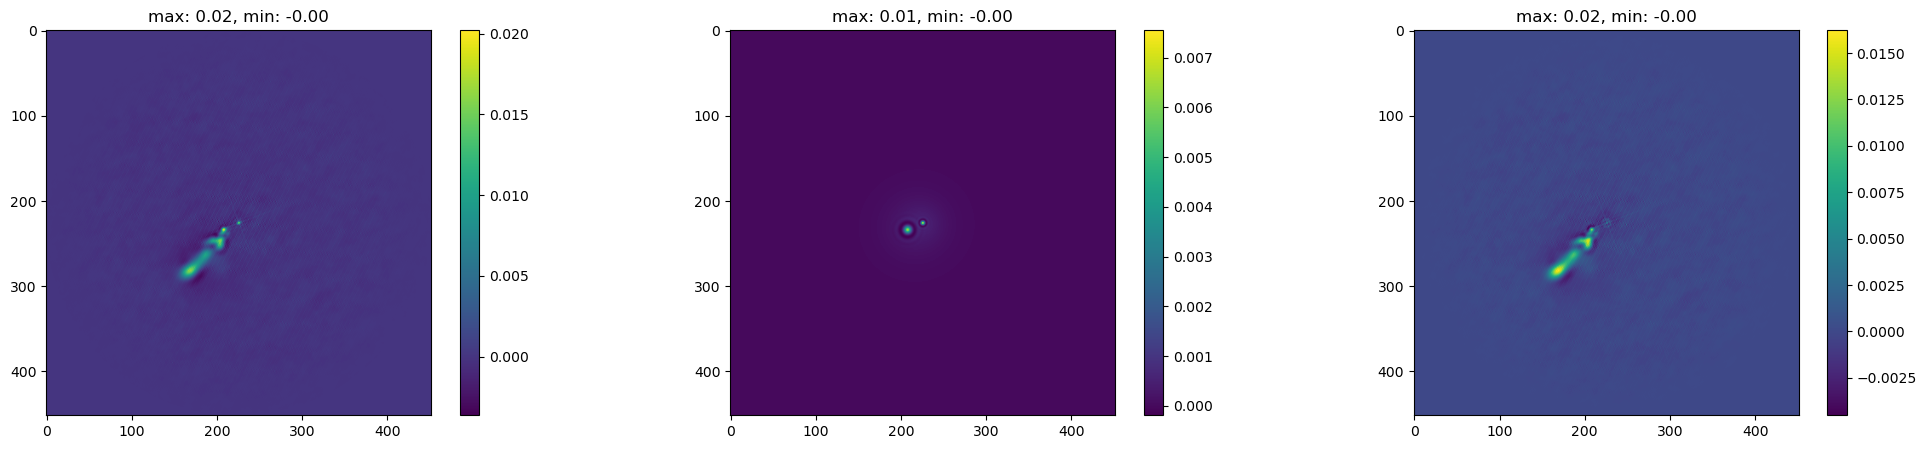

In [9]:
comps, residual, clean = CLEAN(data, gain=0.5, thresh=0.0043, niter=2)

# изучить алгоритм симуляции отжига
# CLEAN(data, gain=1, thresh=np.mean(data), niter=150) - неплохие настройки

fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5)) 
fig.colorbar(ax.imshow(data), ax=ax) 
fig.colorbar(ax2.imshow(clean), ax=ax2) 
fig.colorbar(ax3.imshow(residual), ax=ax3) 
ax.set_title(f'max: {np.max(data):.2f}, min: {np.min(data):.2f}') 
ax2.set_title(f'max: {np.max(clean):.2f}, min: {np.min(clean):.2f}') 
ax3.set_title(f'max: {np.max(residual):.2f}, min: {np.min(residual):.2f}')
print('')

2000.0000002
6700.0
2000.0000002
6700.0
2000.0000002
6700.0
2000.0000002
6700.0
2000.0000300023223
6700.0
2000.0000002
6700.0
2000.0000002
6700.0
2000.0000002
6700.0
2000.0000002
6700.00009983778
2000.0000002
6700.0
2000.0000002
6700.0
2000.0000002
6700.0
2000.0000002
6700.0
2000.0000300023223
6700.0
2000.0000002
6700.0
2000.0000002
6700.0
2000.0000002
6700.0
2000.0000002
6700.00009983778
2000.0000002
6700.0
Time: 0.3951
4.313896976146223e-28 2.466754854263419e-28 -2.2627346962613526e-14 2000.0000002
-4.0 -2.0 3.3445799220484885e-14 6700.0



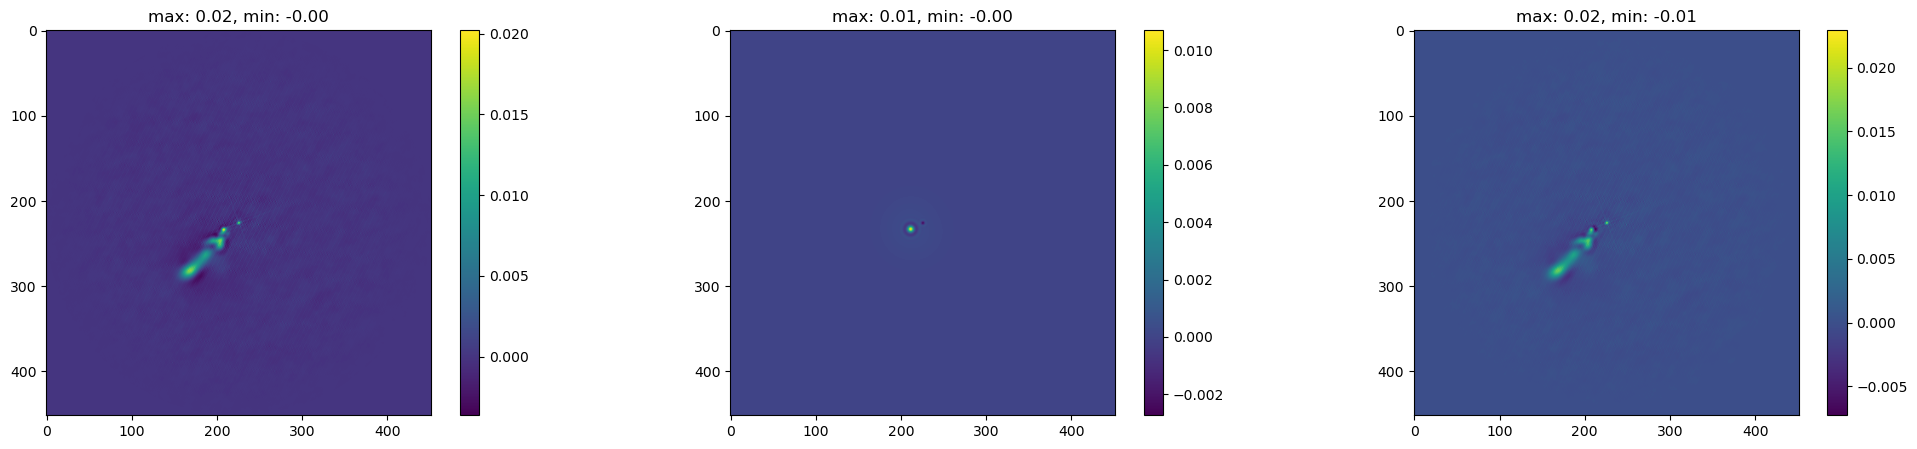

In [245]:
h = 2*np.logspace(3, 5, 100)
p = [(0, 0, 1e-13, 2000),
    (-4, -2, 2e-12, 6700)]
fit = one_speckle_fit(params=p)

fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5)) 
fig.colorbar(ax.imshow(data), ax=ax) 
fig.colorbar(ax2.imshow(fit), ax=ax2) 
fig.colorbar(ax3.imshow(data-fit), ax=ax3) 
ax.set_title(f'max: {np.max(data):.2f}, min: {np.min(data):.2f}') 
ax2.set_title(f'max: {np.max(fit):.2f}, min: {np.min(fit):.2f}') 
ax3.set_title(f'max: {np.max(data-fit):.2f}, min: {np.min(data-fit):.2f}')
print('')